In [1]:
import numpy as np
import parser
import pandas as pd
import sys
import random
# chunksize = 10 ** 8
# for chunk in pd.read_csv('1mb.txt', chunksize=chunksize,delimiter=' '):
#     process(chunk)
# files=['1mb_short.txt','5mb_short.txt','10mb_short.txt','50mb_short.txt','100mb_short.txt']
# file='10mb_0.9_short.txt'    
# data=pd.read_csv(file,delimiter=' ')
# data.head()
# X = data.as_matrix()
# print(X)
# print(np.shape(X))

In [25]:
len(set(X[:,1]))

978832

In [2]:
###########Parameters###########################
props={}
writes=[0,0]
reads=[0,0]
num_writes=[0,0]
num_reads=[0,0]
avgtime=0
storequeue=[[],[]]
pending=[[],[]]
updatedids=[]
rank=np.ones((2,1))
thr=[0,0]
satisqueue=[]
dramchan=8
nvmchan=8
delta=500
num_chan=32
currsize=[0,0]
size=[256000000,2000000000]
chan=np.ones((2,num_chan))
miss=0
chanstats=np.zeros((2,num_chan))
#PerRankPerBank Policy Implemented
#Store 0:DRAM, 1:NVM, 2:HDD


In [45]:
# for i in range(np.shape(X)[0]):
#     updateprops(X[i])
#     print(props.items(),i)
    

In [3]:
def updateprops(request,store):
    if(request[1] in props):
        value=props[request[1]]
        value[request[2]]=value[request[2]]+1
        props.update({request[1]:value})
    else:
        props[request[1]]=[0,0,request[3],store]
        value=props[request[1]]
        value[request[2]]=value[request[2]]+1
        props.update({request[1]:value})

###################################################################################################
def allocatestore(request):
    idrank=findrank(request)
#     print(request,idrank[0],thr[0]*rank[0],rank[0])
    if(idrank[0]>thr[0]*rank[0] and currsize[0]+request[3]<size[0]):
                if(rank[0]>idrank[0]):
                    rank[0]=idrank[0]
                currsize[0]+=request[3]
                return 0
    elif(idrank[1]>thr[1]*rank[1] and (currsize[1]+request[3])<size[1]):
            currsize[1]+=request[3]
            return 1
    else:
        return 2
 
        
#########################################################################################################
def findrank(rid):
    if(rid[1] in props):
        value=props[rid[1]]
        global h
        return [((value[1]^h+1)*(value[0]+1))/value[2],(value[0]+1)/(value[2]*(value[1]^h+1))] 
#         return [((value[0]+1))/value[2],(value[0]+1)/(value[2])] 
    else :
            if(rid[2]==0):
                return [2/(rid[3]),(2)/rid[3]]
            else:
                return [2/(rid[3]),2/rid[3]]    

In [4]:
def getfreechannel(i):
    return sum(chan[i])
    
def ischannelfree(i,channel):
    return chan[i,channel]

def allocatechan(j):
    channels=[i for i, x in enumerate(chan[j]) if x]
    channel=random.choice(channels)
#     print(channels)
    chan[i,channel]=0
    chanstats[i,channel]+=1
    return channel

def setchan(i,channel):
    chan[i,channel]=0

In [5]:
def onecycle(i,clock):
    while(X[i,0]<clock+delta and i<(np.shape(X)[0]-1)):   
        if (X[i,1] not in props):
            store=allocatestore(X[i])
            if(store<2):
                storequeue[store].append([X[i],"store"]) 
        else:
            store=props[X[i,1]][3]
            if(store<2):
                if(X[i,2]):
                    storequeue[store].append([X[i],"write"])
                else:
                    storequeue[store].append([X[i],"read"])
            else:
                global miss
                if(X[i,2]):
                    miss[1]+=1
                else:
                    miss[0]+=1
        updateprops(X[i],store)    
        i+=1
    storequeue[0].sort(key= lambda x : int(x[0][0]))
    storequeue[1].sort(key= lambda x : int(x[0][0]))
    global updatedids
    updatedids=[]
    satisfyrequests(0,clock)
    satisfyrequests(1,clock)
    runevictions(clock)
    return i

#################################################################################################    
def satisfyrequests(i,clock):
    temp=[]
    while(len(storequeue[i])>0 and getfreechannel(i)>0):
        request=storequeue[i].pop(0)
        if(request[0][0]<clock):
                if(request[1]=='store'):
                    chan=allocatechan(i)
                    value=props[request[0][1]]
                    value[3]=i
                    value.append(chan)
                    props.update({request[0][1]:value})
                elif(request[1]=='read' or request[1]=='write'):
                    if(len(props[request[0][1]])==4):
                        temp.append(request)
                    elif(ischannelfree(i,props[request[0][1]][4])==0):
                        temp.append(request)
                    else:
                        if(request[1]=='write'):
                            writes[i]+=request[0][1]
                            num_writes[i]+=1
                        else:
                            num_reads[i]+=1
                            reads[i]+=request[0][1]
                        setchan(i,props[request[0][1]][4])
                        updatedids.append(request[0])      
                elif(request[1]=='evict'):
                    if(ischannelfree(i,props[request[0][1]][4])==0):
                        temp.append(request)
                    else:
                        storequeue[request[2]].append([request[0],"store"])
        else:
            storequeue[i].append(request)
            break
    while(len(temp)>0):
        storequeue[i].append(temp.pop(0))
    return 
#################################################################################################
def runevictions(clock): 
    for key in updatedids:
        idrank=findrank(key)        
        thr[0]= 0 if (currsize[0]/size[0]<0.5) else currsize[0]/size[0]
        thr[1]= 0 if (currsize[1]/size[1]<0.5) else currsize[1]/size[1]
        if(props[key[1]][3]==0):
            if(idrank[0]>thr[0]*rank[0] and idrank[0]<rank[0]):
                rank[0]=idrank[0]
            if(idrank[0]<thr[0]*rank[0] and idrank[1]>thr[1]*rank[1]):         
                if(currsize[1]+key[3]<size[1]):
                    if(rank[0]<idrank[0]):
                        rank[0]=idrank[0]
                    storequeue[0].append([key,"evict",1])
#                     print('eviction added to NVM')
                    currsize[1]+=key[3]
                    currsize[0]-=key[3]
            elif(idrank[0]<thr[0]*rank[0] and idrank[1]<thr[1]*rank[1]):                  
                value=props[key[1]]
                value[3]=2
                props.update({key[1]:value})
                currsize[0]-=key[3]
            
        if(props[key[1]][3]==1):
            if(idrank[0]>2*thr[0]*rank[0]):
                 if(currsize[0]+key[3]<size[0]):   
                        storequeue[1].append([key,"evict",0])
#                         print('eviction added to DRAM')
                        currsize[1]-=key[3]
                        currsize[0]+=key[3]
                        continue
            if(idrank[1]>thr[1]*rank[1] and idrank[1]<rank[1]):
                rank[1]=idrank[1]
            if(idrank[1]<thr[1]*rank[1]):
                value=props[key[1]]
                value[3]=2
                props.update({key[1]:value})
                currsize[1]-=key[3]
        if(props[key[1]][3]==2):
#                 print("from HDD")
                if(idrank[0]>thr[0]*rank[0]):
                    if(currsize[0]+key[3]<size[0]):
                        storequeue[0].append([key,"store"])
                        currsize[0]+=key[3]
                if(idrank[1]>thr[1]*rank[1]):
                    if(currsize[0]+key[3]<size[0]):
                        storequeue[1].append([key,"store"])
                        currsize[1]+=key[3]

In [6]:
def reset():
    for keys in props:
        if(props[keys][0]==0 and props[keys][3]==0):
            if(props[keys][2]>10000):
                currsize[0]-=props[keys][2]
                if(2/props[keys][2]>thr[1]*rank[1]):
                    props[keys]=[0,0,props[keys][2],1,random.randrange(1,32)]
                    currsize[1]+=props[keys][2]
                else:
                    props[keys]=[0,0,props[keys][2],2]
    for keys in props:
        if(len(props[keys])==5):
            props[keys]=[0,0,props[keys][2],props[keys][3],props[keys][4]]
        if(len(props[keys])==4):
            props[keys]=[0,0,props[keys][2],props[keys][3]]

In [7]:
def runsim():
    cycles=0
    i=0
    last=0
    clock=0
    while(i<np.shape(X)[0]-1):
#         print(i,cycles,currsize,thr,num_writes,num_reads)
        i=onecycle(i,clock)
        global chan
        chan =np.ones((2,num_chan))
        clock+=500
        cycles+=1
        if(cycles%20000==0):
            reset()
            print(cycles,i,len(storequeue[0]))
    while(len(storequeue[0])>0 or len(storequeue[1])>0):
        chan =np.ones((2,num_chan))
        satisfyrequests(0,clock)
        satisfyrequests(1,clock)
        print(len(storequeue[0]),len(storequeue[1]))
        clock+=500
        cycles+=1
    

In [16]:
files=['1mb_0.7_short.txt','2mb_0.7_short.txt','5mb_0.7_short.txt','10mb_0.7_short.txt','20mb_0.7_short.txt','1mb_0.8_short.txt','2mb_0.8_short.txt','5mb_0.8_short.txt','10mb_0.8_short.txt','20mb_0.8_short.txt','1mb_0.9_short.txt','2mb_0.9_short.txt','5mb_0.9_short.txt','10mb_0.9_short.txt','20mb_0.9_short.txt']
# '1mb_0.7_short.txt','2mb_0.7_short.txt'
global h
h=2
# file='2mb_0.7_short.txt'
for file in files:
        global X,props,writes,reads,num_writes,num_reads,miss,currsize,storequeue
        data=pd.read_csv(file,delimiter=' ')
        data.head()
        X = data.as_matrix()
        #         print(X)
        #         print(np.shape(X))
        props={}
        writes=[0,0]
        reads=[0,0]
        num_writes=[0,0]
        num_reads=[0,0]
        avgtime=0
        storequeue=[[],[]]
        pending=[[],[]]
        updatedids=[]
        rank=np.ones((2,1))
        thr=[0,0]
        satisqueue=[]
        dramchan=8
        nvmchan=8
        delta=500
        num_chan=128
        currsize=[0,0]
        size=[256000000,4000000000]
        chan=np.ones((2,num_chan))
        miss=[0,0]
        chanstats=np.zeros((2,num_chan))
        i=0
        cycles=0
        runsim()
        print(writes,reads,num_writes,num_reads,miss)

/home/khushal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/home/khushal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in long_scalars


20000 379330 24
40000 759633 16
60000 1139722 22
80000 1519755 13
100000 1898975 13
120000 2277503 15
140000 2658461 15
160000 3036956 16
180000 3416310 21
200000 3795871 14
220000 4176089 15
240000 4555249 12
260000 4934892 8
280000 5314696 10
300000 5693827 26
320000 6073676 7
340000 6454766 11
360000 6834336 15
380000 7214658 21
400000 7593569 15
420000 7973403 14
440000 8353334 14
460000 8732457 10
480000 9112795 10
500000 9492566 11
520000 9871562 12
540000 10250735 14
560000 10629714 11
580000 11008803 17
600000 11387422 12
620000 11766293 13
640000 12145903 17
660000 12525516 14
680000 12906021 11
700000 13286035 17
720000 13664759 10
740000 14043546 7
760000 14423034 18
780000 14803405 23
800000 15182223 17
820000 15562119 8
840000 15942143 17
860000 16321865 21
880000 16701264 12
900000 17081028 13
920000 17460104 18
940000 17840168 11
960000 18219490 11
980000 18599486 11
1000000 18979354 12
1 0
0 0
[1053499467200, 647524272182] [457075987476, 990381370477] [2342961, 1247035]

/home/khushal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in long_scalars


80000 1520496 17
100000 1901087 9
120000 2281465 17


/home/khushal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in long_scalars


140000 2660812 13
160000 3040693 9
180000 3421017 12
200000 3800999 9
220000 4182391 20
240000 4562262 7
260000 4942414 8
280000 5322577 8
300000 5703322 10
320000 6082111 15
340000 6462555 7
360000 6840090 7
380000 7219550 12
400000 7599572 11
420000 7979500 14
440000 8359264 12
460000 8739164 8
480000 9118436 9
500000 9498323 11
520000 9878351 8
540000 10257637 15
560000 10638106 11
580000 11018153 12
600000 11399742 8
620000 11778987 11
640000 12158967 13
660000 12538273 9
680000 12917892 8
700000 13296792 8
720000 13677242 17
740000 14056886 11
760000 14436562 15
780000 14816624 11
800000 15196522 9
820000 15576066 9
840000 15955363 8
860000 16335317 9
880000 16716290 14
900000 17096270 14
920000 17475865 11
940000 17855490 9
960000 18235798 11
980000 18616371 13
1000000 18996078 8
0 0
[850398499466, 845426765590] [266098381182, 1183026547380] [1927262, 1665877] [8668294, 5755830] [0, 0]
20000 379034 11
40000 759523 11
60000 1140532 13
80000 1520496 18
100000 1901087 12
120000 2281

240000 4556326 6
260000 4936233 15
280000 5315899 5
300000 5696258 7
320000 6076024 12
340000 6455576 4
360000 6835943 6
380000 7215698 7
400000 7593857 12
420000 7974917 9
440000 8355269 8
460000 8735367 13
480000 9114611 12
500000 9494446 12
520000 9874632 10
540000 10254942 9
560000 10633820 10
580000 11014920 9
600000 11394269 8
620000 11774237 8
640000 12153768 5
660000 12533778 13
680000 12913751 8
700000 13293924 8
720000 13673233 11
740000 14053305 6
760000 14432824 8
780000 14811548 10
800000 15191592 7
820000 15572052 15
840000 15950790 9
860000 16330180 12
880000 16710124 12
900000 17089967 16
920000 17469151 5
940000 17847933 10
960000 18227759 8
980000 18606291 15
1000000 18986670 16
3 0
2 0
1 0
0 0
[497532502137, 860767186397] [46035221027, 514487134918] [1055509, 1763146] [7646388, 4331077] [2436978, 774740]
20000 380318 10
40000 760450 7
60000 1140601 7
80000 1520285 4
100000 1899386 4
120000 2278387 11
140000 2658536 10
160000 3038864 10
180000 3418076 8
200000 3797574

In [2]:
h0_writes=np.array(((0.6526361032,0.3473638968,0),(0.5363727927,0.4636272073,0),(0.3912996541,0.5478804492,0.06081989668),(0.2613915253,0.5150004383,0.2236080364),
(0.1344451001,0.4174598125,0.4480950874),(0.5185324141,0.4814675859,0),(0.3865429449,0.6134570551,0),(0.2358023309,0.6598002342,0.1043974349),(0.1366992028,0.5270143902,0.336286407),
(0.08345409206,0.3998608752,0.5166850327),(0.4304401876,0.5695598124,0),(0.2967699197,0.7032300803,0),
(0.1493818079,0.702840534,0.1477776581),(0.08861681553,0.4782896501,0.4330935344),(0.0367340403,0.3173516119,0.6459143478)))

In [3]:
h0_reads=np.array((0.6921050387,0.3078949613,0,
0.6009580894,0.3990419106,0,0.5327920222,0.4174299893,0.04977798858,0.5223762028,0.3088528638,0.1687709334,
0.4723937723,0.2504146191,0.2771916085,
0.5916906024,0.4083093976,0,
0.4782714774,0.5217285226,0,
0.3916324516,0.5088930054,0.09947454307,
0.3487744985,0.3754641501,0.2757613514,
0.3094068423,0.2702321101,0.4203610477,
0.5143831928,0.4856168072,0,
0.3951121914,0.6048878086,0,
0.2802412336,0.5717844885,0.1479742779,
0.2319213019,0.3901135727,0.3779651254,
0.1872554842,0.2611586284,0.5515858873))

In [4]:
h2_writes=np.array((0.5731201372,0.4268798628,0,0.4051961252,0.5948038748,0,0.3660542997,0.5719686251,0.06197707512,0.2937358682,0.4906630081,
0.2156011237,0.1906383672,0.3831262802,0.4262353525,
0.440797321,0.559202679,0,0.2672528324,0.7327471676,0,0.225944751,0.6685,0.105465,0.16278,0.4970,0.3401,
0.1064894293,0.3642026674,0.5293079034,0.3240780963,0.675921,0,0.1946675109,0.8053324891,0,0.1324294678,
0.7195779448,0.1479925873,0.09159319491,0.47111029,0.4372965065,0.05937866542,0.3029317337,0.6376896009))

In [5]:
h2_reads=((0.7595312185,0.2404687815,0,
0.6652987038,0.3347012962,0,
0.577482327,0.3727353815,0.04978229153,
0.5304671155,0.300467871,0.1690650135,
0.4786128684,0.2435010512,0.2778860804,
0.6227844732,0.3772155268,0,
0.5005116079,0.4994883921,0,
0.3993635767,0.5011651752,0.09947124814,
0.3510169927,0.3726597062,0.2763233011,
0.3052583999,0.2734282843,0.4213133158,
0.5141755334,0.4858244666,0,
0.3785619582,0.6214380418,0,
0.2672184785,0.5847489935,0.148032528,
0.2232136641,0.3983868737,0.3783994622,
0.1823678748,0.2653492464,0.5522828788))

In [6]:
h1_writes=((0.5847120721,0.4152879279,0,
0.4377501121,0.5622498879,0,
0.3744631112,0.5664857306,0.05905115819,
0.294893826,0.4896480905,0.2154580835,
0.1906205698,0.3842202681,0.4251591622,
0.4394409528,0.5605590472,0,
0.2852748481,0.7147251519,0,
0.2249906771,0.6691318435,0.1058774794,
0.1569155574,0.4926831208,0.3504013217,
0.1151375935,0.364625537,0.5202368695,
0.349111277,0.650888723,0,
0.2170090713,0.7829909287,0,
0.1394567705,0.7125456298,0.1479975997,
0.09277113234,0.4695861681,0.4376426995,
0.05983823123,0.3017786158,0.638383153))

In [7]:
h1_reads=((0.7611092101,0.2388907899,0,
0.6678076256,0.3321923744,0,
0.5833123391,0.3669124484,0.04977521248,
0.5326026125,0.2982965072,0.1691008803,
0.4801094865,0.2419331127,0.2779574008,
0.6335673176,0.3664326824,0,
0.5092372265,0.4907627735,0,
0.4052059273,0.4953263987,0.09946767398,
0.3541196654,0.3694920386,0.2763882961,
0.3063383296,0.2722826809,0.4213789895,
0.5303985712,0.4696014288,0,
0.3972989405,0.6027010595,0,
0.2780294345,0.5739337263,0.1480368391,
0.2287384379,0.3927918742,0.3784696879,
0.1842848143,0.2632939008,0.5524212849))

In [8]:
h0_reads=np.reshape(h0_reads,(3,5,3))
h0_writes=np.reshape(h0_writes,(3,5,3))
h1_reads=np.reshape(h1_reads,(3,5,3))
h1_writes=np.reshape(h1_writes,(3,5,3))
h2_reads=np.reshape(h2_reads,(3,5,3))
h2_writes=np.reshape(h2_writes,(3,5,3))

In [9]:
print(h0_reads)

[[[0.69210504 0.30789496 0.        ]
  [0.60095809 0.39904191 0.        ]
  [0.53279202 0.41742999 0.04977799]
  [0.5223762  0.30885286 0.16877093]
  [0.47239377 0.25041462 0.27719161]]

 [[0.5916906  0.4083094  0.        ]
  [0.47827148 0.52172852 0.        ]
  [0.39163245 0.50889301 0.09947454]
  [0.3487745  0.37546415 0.27576135]
  [0.30940684 0.27023211 0.42036105]]

 [[0.51438319 0.48561681 0.        ]
  [0.39511219 0.60488781 0.        ]
  [0.28024123 0.57178449 0.14797428]
  [0.2319213  0.39011357 0.37796513]
  [0.18725548 0.26115863 0.55158589]]]


In [13]:
h0_reads=np.reshape(h0_reads,(15,3))
h0_writes=np.reshape(h0_writes,(15,3))
h1_reads=np.reshape(h1_reads,(15,3))
h1_writes=np.reshape(h1_writes,(15,3))
h2_reads=np.reshape(h2_reads,(15,3))
h2_writes=np.reshape(h2_writes,(15,3))

In [14]:
print(h0_writes[:,2])

[0.         0.         0.0608199  0.22360804 0.44809509 0.
 0.         0.10439743 0.33628641 0.51668503 0.         0.
 0.14777766 0.43309353 0.64591435]


In [15]:
print(h0_writes)

[[0.6526361  0.3473639  0.        ]
 [0.53637279 0.46362721 0.        ]
 [0.39129965 0.54788045 0.0608199 ]
 [0.26139153 0.51500044 0.22360804]
 [0.1344451  0.41745981 0.44809509]
 [0.51853241 0.48146759 0.        ]
 [0.38654294 0.61345706 0.        ]
 [0.23580233 0.65980023 0.10439743]
 [0.1366992  0.52701439 0.33628641]
 [0.08345409 0.39986088 0.51668503]
 [0.43044019 0.56955981 0.        ]
 [0.29676992 0.70323008 0.        ]
 [0.14938181 0.70284053 0.14777766]
 [0.08861682 0.47828965 0.43309353]
 [0.03673404 0.31735161 0.64591435]]


In [16]:
read_dram=np.array((45.82797049,30.69789525,14.87503813,6.598399892,2.863076534,82.86330461,
60.62123805,28.76952016,14.16642278,6.159285637,126.8165508,98.64886704,47.72656137,23.92377636,11.16930671))

In [17]:
read_nvm=((223.210238, 205.5353524,162.0922139, 115.0115117,73.3777161, 279.7157899,257.298019,
198.8046681,135.7087599, 97.90925564,327.0000076, 305.8560149,235.6828484,171.1541606,127.9121478))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


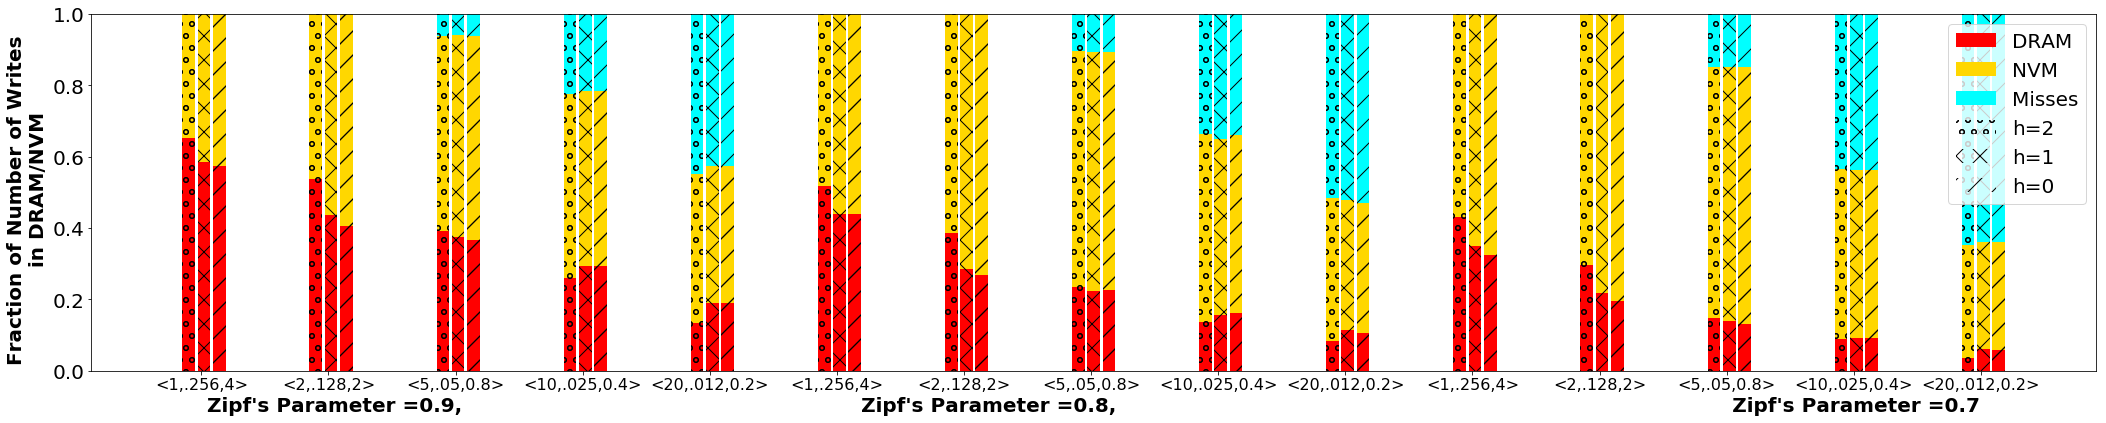

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
import matplotlib as mpl
# mpl.rcParams['text.usetex'] = False?
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

n_groups = 15
fig, ax = plt.subplots(figsize=(30,6))
index = np.arange(n_groups)
print(index)
bar_width = 0.05
ax.set_yscale('linear')
# opacity = 0.4
error_config = {'ecolor': '0.3'}
index = np.arange(n_groups)
# print(index)
bar_width = 0.1
# ax.set_yscale('log')
opacity = 0.1
error_config = {'ecolor': '0.3'}
#


rects1 = ax.bar(index+bar_width,h0_writes[:,0], bar_width, color='red', error_kw=error_config,label='DRAM')+ax.bar(index+bar_width, h0_writes[:,1], bar_width, bottom=h0_writes[:,0], color='gold', error_kw=error_config,label='NVM')+ax.bar(index+bar_width, h0_writes[:,2], bar_width,bottom=h0_writes[:,0]+h0_writes[:,1],color='aqua', error_kw=error_config,label='Misses')
rects1 = ax.bar(index+bar_width, h0_writes[:,0]+h0_writes[:,1]+h0_writes[:,2], bar_width, color='none', error_kw=error_config,label='h=2',hatch='o')
rects2 = ax.bar(index + 2.2*bar_width,h1_writes[:,0]  , bar_width, color='red', error_kw=error_config)+ax.bar(index + 2.2*bar_width, h1_writes[:,1] , bar_width,bottom=h1_writes[:,0], color='gold', error_kw=error_config)+ax.bar(index+2.2*bar_width,h1_writes[:,2] , bar_width,bottom=h1_writes[:,0]+h1_writes[:,1],color='aqua', error_kw=error_config)
rects2 = ax.bar(index + 2.2*bar_width, h1_writes[:,0]+h1_writes[:,1]+h1_writes[:,2], bar_width, color='none',hatch='x', error_kw=error_config,label='h=1')
rects3 = ax.bar(index + 3.4*bar_width, h2_writes[:,0] , bar_width, color='red',hatch='/',error_kw=error_config)+ax.bar(index + 3.4*bar_width, h2_writes[:,1] , bar_width, bottom=h2_writes[:,0], color='gold',hatch='/',error_kw=error_config)+ax.bar(index+3.4*bar_width, h2_writes[:,2], bar_width,bottom= h2_writes[:,0]+h2_writes[:,1],color='aqua', error_kw=error_config)
rects3 = ax.bar(index + 3.4*bar_width, h2_writes[:,0]+h2_writes[:,1]+h2_writes[:,2], bar_width, color='none',hatch='/',error_kw=error_config,label='h=0')

# ax.set_ylabel('SpeedUp (GraphMat=1)',fontsize=14,fontweight='bold')
ax.set_xticks(index + bar_width*2)
ax.set_xticklabels(('<1,.256,4>', '<2,.128,2>', '<5,.05,0.8>','<10,.025,0.4>','<20,.012,0.2>','<1,.256,4>', '<2,.128,2>', '<5,.05,0.8>','<10,.025,0.4>','<20,.012,0.2>','<1,.256,4>', '<2,.128,2>', '<5,.05,0.8>','<10,.025,0.4>','<20,.012,0.2>'))
ax.set_ylabel('Fraction of Number of Writes  \n in DRAM/NVM',fontsize=20,fontweight='bold')
ax.set_xlabel('Zipf\'s Parameter =0.9,                                                         Zipf\'s Parameter =0.8,                                                                                        Zipf\'s Parameter =0.7',fontsize=20,fontweight='bold')
ax.legend(fontsize=20)
# ax.set_ylim( (pow(10,-2),pow(10,3)))
fig.tight_layout()
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)
plt.savefig('data_writes.png', bbox_inches = 'tight')
plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


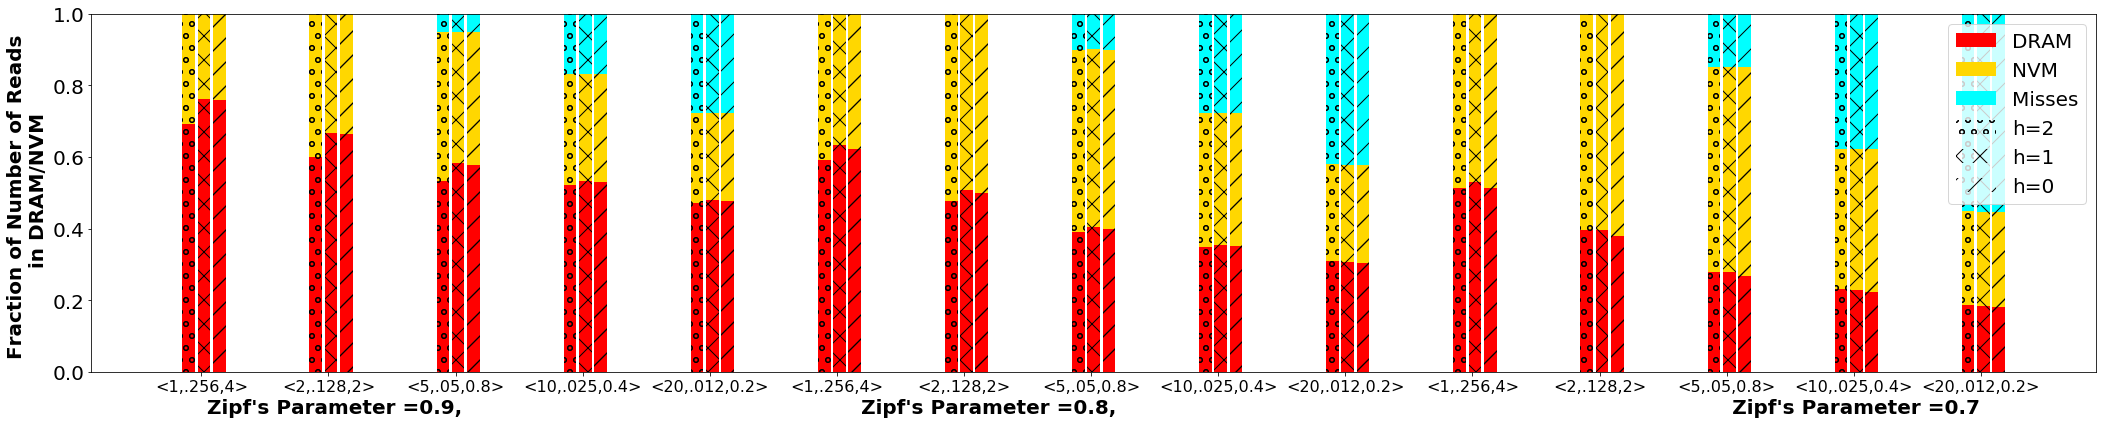

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
import matplotlib as mpl
# mpl.rcParams['text.usetex'] = False?
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']


fig, ax = plt.subplots(figsize=(30,6))
index = np.arange(n_groups)
print(index)
bar_width = 0.05
ax.set_yscale('linear')
# opacity = 0.4
error_config = {'ecolor': '0.3'}
index = np.arange(n_groups)
# print(index)
bar_width = 0.1
# ax.set_yscale('log')
opacity = 0.1
error_config = {'ecolor': '0.3'}
#

n_groups = 15
rects1 = ax.bar(index+bar_width,h0_reads[:,0], bar_width, color='red', error_kw=error_config,label='DRAM')+ax.bar(index+bar_width, h0_reads[:,1], bar_width, bottom=h0_reads[:,0], color='gold', error_kw=error_config,label='NVM')+ax.bar(index+bar_width, h0_reads[:,2], bar_width,bottom=h0_reads[:,0]+h0_reads[:,1],color='aqua', error_kw=error_config,label='Misses')
rects1 = ax.bar(index+bar_width, h0_reads[:,0]+h0_reads[:,1]+h0_reads[:,2], bar_width, color='none', error_kw=error_config,label='h=2',hatch='o')
rects2 = ax.bar(index + 2.2*bar_width,h1_reads[:,0]  , bar_width, color='red', error_kw=error_config)+ax.bar(index + 2.2*bar_width, h1_reads[:,1] , bar_width,bottom=h1_reads[:,0], color='gold', error_kw=error_config)+ax.bar(index+2.2*bar_width,h1_reads[:,2] , bar_width,bottom=h1_reads[:,0]+h1_reads[:,1],color='aqua', error_kw=error_config)
rects2 = ax.bar(index + 2.2*bar_width, h1_reads[:,0]+h1_reads[:,1]+h1_reads[:,2], bar_width, color='none',hatch='x', error_kw=error_config,label='h=1')
rects3 = ax.bar(index + 3.4*bar_width, h2_reads[:,0] , bar_width, color='red',hatch='/',error_kw=error_config)+ax.bar(index + 3.4*bar_width, h2_reads[:,1] , bar_width, bottom=h2_reads[:,0], color='gold',hatch='/',error_kw=error_config)+ax.bar(index+3.4*bar_width, h2_reads[:,2], bar_width,bottom= h2_reads[:,0]+h2_reads[:,1],color='aqua', error_kw=error_config)
rects3 = ax.bar(index + 3.4*bar_width, h2_reads[:,0]+h2_reads[:,1]+h2_reads[:,2], bar_width, color='none',hatch='/',error_kw=error_config,label='h=0')

# ax.set_ylabel('SpeedUp (GraphMat=1)',fontsize=14,fontweight='bold')
ax.set_xticks(index + bar_width*2)
ax.set_xticklabels(('<1,.256,4>', '<2,.128,2>', '<5,.05,0.8>','<10,.025,0.4>','<20,.012,0.2>','<1,.256,4>', '<2,.128,2>', '<5,.05,0.8>','<10,.025,0.4>','<20,.012,0.2>','<1,.256,4>', '<2,.128,2>', '<5,.05,0.8>','<10,.025,0.4>','<20,.012,0.2>'))
ax.set_ylabel('Fraction of Number of Reads \n in DRAM/NVM',fontsize=20,fontweight='bold')
ax.set_xlabel('Zipf\'s Parameter =0.9,                                                         Zipf\'s Parameter =0.8,                                                                                        Zipf\'s Parameter =0.7',fontsize=20,fontweight='bold')

ax.legend(fontsize=20)
# ax.set_ylim( (pow(10,-2),pow(10,3)))
fig.tight_layout()
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)
plt.savefig('data_reads.png', bbox_inches = 'tight')
plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


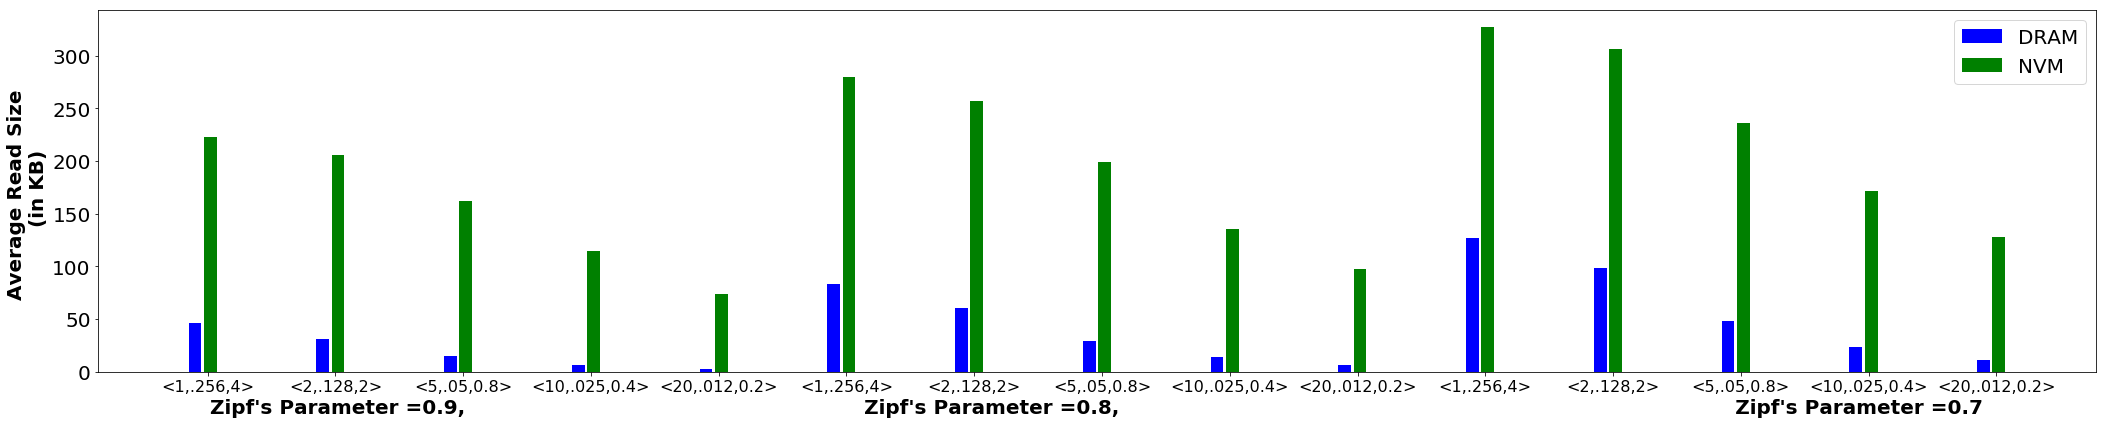

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
import matplotlib as mpl
# mpl.rcParams['text.usetex'] = False?
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']


fig, ax = plt.subplots(figsize=(30,6))
index = np.arange(n_groups)
print(index)
bar_width = 0.05
ax.set_yscale('linear')
# opacity = 0.4
error_config = {'ecolor': '0.3'}
index = np.arange(n_groups)
# print(index)
bar_width = 0.1
# ax.set_yscale('log')
opacity = 0.1
error_config = {'ecolor': '0.3'}
#

n_groups = 15
rects1 = ax.bar(index+bar_width,read_dram, bar_width, color='blue', error_kw=error_config,label='DRAM')
rects2 = ax.bar(index + 2.2*bar_width,read_nvm, bar_width, color='green', error_kw=error_config,label='NVM')

# ax.set_ylabel('SpeedUp (GraphMat=1)',fontsize=14,fontweight='bold')
ax.set_xticks(index + bar_width*2)
ax.set_xticklabels(('<1,.256,4>', '<2,.128,2>', '<5,.05,0.8>','<10,.025,0.4>','<20,.012,0.2>','<1,.256,4>', '<2,.128,2>', '<5,.05,0.8>','<10,.025,0.4>','<20,.012,0.2>','<1,.256,4>', '<2,.128,2>', '<5,.05,0.8>','<10,.025,0.4>','<20,.012,0.2>'))
ax.set_ylabel('Average Read Size \n (in KB)',fontsize=20,fontweight='bold')
ax.legend(fontsize=20)
ax.set_xlabel('Zipf\'s Parameter =0.9,                                                         Zipf\'s Parameter =0.8,                                                                                        Zipf\'s Parameter =0.7',fontsize=20,fontweight='bold')
fig.tight_layout()
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)
plt.savefig('read_avg.png', bbox_inches = 'tight')
plt.show()

In [18]:
optimal_writes= np.array((0.7717162618,0.2282837382,0,
0.6875940698,0.3124059302,0,
0.5833772907,0.2183154655,0.1983072438,
0.5142767895,0.1458078021,0.3399154083,
0.4487632611,0.09797117346,0.4532655654,
0.7307932879,0.2692067121,0,
0.6144977956,0.3855022044,0,
0.4782093743,0.2332984303,0.2884921954,
0.3939722022,0.145271964,0.4607558338,
0.3222275636,0.0937067495,0.5840656868,
0.6912767686,0.3087232314,0,
0.5465582886,0.4534417114,0,
0.3898140971,0.2502154874,0.3599704155,
0.2991758225,0.1436417067,0.5571824708,
0.2279838061,0.08921174135,0.6828044526))


In [19]:
optimal_reads=np.array((0.7759072326,0.2240927674,0,
0.6971592465,0.3028407535,0,0.6005530107,0.3670282607,0.0324187286,
0.5360994185,0.3447927013,0.1191078802,
0.4590334485,0.3229404538,0.2180260977,
0.6708327771,0.3291672229,0,
0.5736082523,0.4263917477,0,
0.4468657461,0.4902000368,0.06293421703,
0.3774363087,0.426290054,0.1962736373,
0.3219113746,0.3356800067,0.3424086186,
0.5828059315,0.4171940685,0,
0.4646755257,0.5353244743,0,
0.3420758326,0.5632495567,0.09467461067,
0.2674843693,0.4627417923,0.2697738384,
0.209047827,0.3436361197,0.4473160533))

In [20]:
optimal_reads=np.reshape(optimal_reads,(3,5,3))
optimal_writes=np.reshape(optimal_writes,(3,5,3))

In [21]:
optimal_reads=np.reshape(optimal_reads,(15,3))
optimal_writes=np.reshape(optimal_writes,(15,3))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


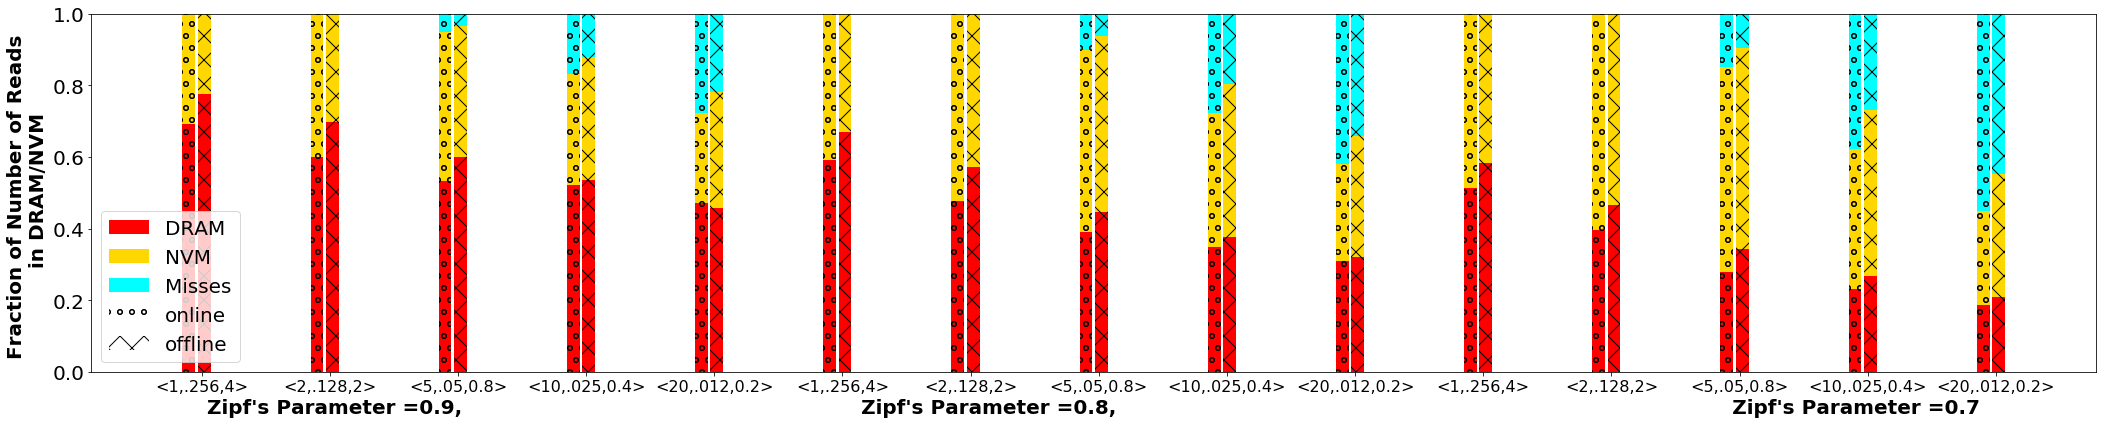

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
import matplotlib as mpl
# mpl.rcParams['text.usetex'] = False?
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

n_groups = 15
fig, ax = plt.subplots(figsize=(30,6))
index = np.arange(n_groups)
print(index)
bar_width = 0.05
ax.set_yscale('linear')
# opacity = 0.4
error_config = {'ecolor': '0.3'}
index = np.arange(n_groups)
# print(index)
bar_width = 0.1
# ax.set_yscale('log')
opacity = 0.1
error_config = {'ecolor': '0.3'}
#


rects1 = ax.bar(index+bar_width,h0_reads[:,0], bar_width, color='red', error_kw=error_config,label='DRAM')+ax.bar(index+bar_width, h0_reads[:,1], bar_width, bottom=h0_reads[:,0], color='gold', error_kw=error_config,label='NVM')+ax.bar(index+bar_width, h0_reads[:,2], bar_width,bottom=h0_reads[:,0]+h0_reads[:,1],color='aqua', error_kw=error_config,label='Misses')
rects1 = ax.bar(index+bar_width, h0_reads[:,0]+h0_reads[:,1]+h0_reads[:,2], bar_width, color='none', error_kw=error_config,label='online',hatch='o')
rects2 = ax.bar(index + 2.2*bar_width,optimal_reads[:,0]  , bar_width, color='red', error_kw=error_config)+ax.bar(index + 2.2*bar_width, optimal_reads[:,1] , bar_width,bottom=optimal_reads[:,0], color='gold', error_kw=error_config)+ax.bar(index+2.2*bar_width,optimal_reads[:,2] , bar_width,bottom=optimal_reads[:,0]+optimal_reads[:,1],color='aqua', error_kw=error_config)
rects2 = ax.bar(index + 2.2*bar_width, optimal_reads[:,0]+optimal_reads[:,1]+optimal_reads[:,2], bar_width, color='none',hatch='x', error_kw=error_config,label='offline')
# rects3 = ax.bar(index + 3.4*bar_width, h2_reads[:,0] , bar_width, color='red',hatch='/',error_kw=error_config)+ax.bar(index + 3.4*bar_width, h2_reads[:,1] , bar_width, bottom=h2_reads[:,0], color='gold',hatch='/',error_kw=error_config)+ax.bar(index+3.4*bar_width, h2_reads[:,2], bar_width,bottom= h2_reads[:,0]+h2_reads[:,1],color='aqua', error_kw=error_config)
# rects3 = ax.bar(index + 3.4*bar_width, h2_reads[:,0]+h2_reads[:,1]+h2_reads[:,2], bar_width, color='none',hatch='/',error_kw=error_config,label='h=0')

# ax.set_ylabel('SpeedUp (GraphMat=1)',fontsize=14,fontweight='bold')
ax.set_xticks(index + bar_width*2)
ax.set_xticklabels(('<1,.256,4>', '<2,.128,2>', '<5,.05,0.8>','<10,.025,0.4>','<20,.012,0.2>','<1,.256,4>', '<2,.128,2>', '<5,.05,0.8>','<10,.025,0.4>','<20,.012,0.2>','<1,.256,4>', '<2,.128,2>', '<5,.05,0.8>','<10,.025,0.4>','<20,.012,0.2>'))
ax.set_ylabel('Fraction of Number of Reads \n in DRAM/NVM',fontsize=20,fontweight='bold')
ax.set_xlabel('Zipf\'s Parameter =0.9,                                                         Zipf\'s Parameter =0.8,                                                                                        Zipf\'s Parameter =0.7',fontsize=20,fontweight='bold')

ax.legend(fontsize=20)
# ax.set_ylim( (pow(10,-2),pow(10,3)))
fig.tight_layout()
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)
plt.savefig('comparison_reads.png', bbox_inches = 'tight')
plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


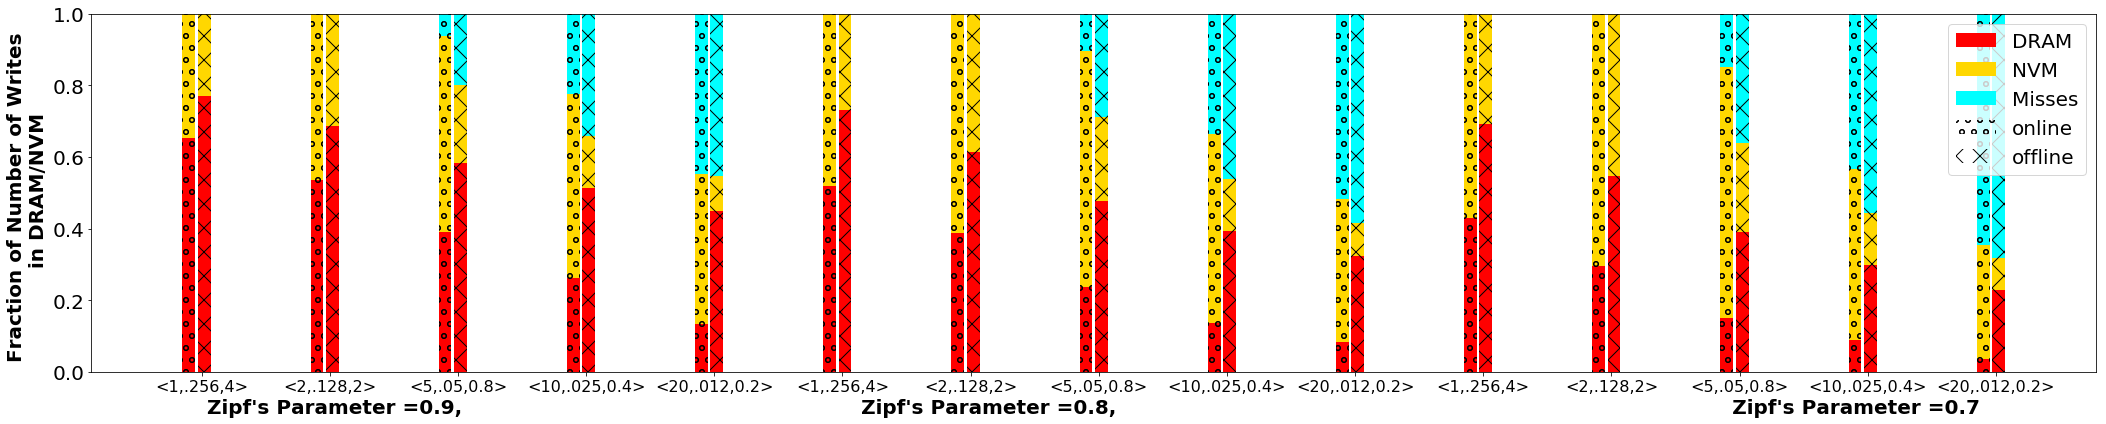

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
import matplotlib as mpl
# mpl.rcParams['text.usetex'] = False?
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

n_groups = 15
fig, ax = plt.subplots(figsize=(30,6))
index = np.arange(n_groups)
print(index)
bar_width = 0.05
ax.set_yscale('linear')
# opacity = 0.4
error_config = {'ecolor': '0.3'}
index = np.arange(n_groups)
# print(index)
bar_width = 0.1
# ax.set_yscale('log')
opacity = 0.1
error_config = {'ecolor': '0.3'}
#


rects1 = ax.bar(index+bar_width,h0_writes[:,0], bar_width, color='red', error_kw=error_config,label='DRAM')+ax.bar(index+bar_width, h0_writes[:,1], bar_width, bottom=h0_writes[:,0], color='gold', error_kw=error_config,label='NVM')+ax.bar(index+bar_width, h0_writes[:,2], bar_width,bottom=h0_writes[:,0]+h0_writes[:,1],color='aqua', error_kw=error_config,label='Misses')
rects1 = ax.bar(index+bar_width, h0_writes[:,0]+h0_writes[:,1]+h0_writes[:,2], bar_width, color='none', error_kw=error_config,label='online',hatch='o')
rects2 = ax.bar(index + 2.2*bar_width,optimal_writes[:,0]  , bar_width, color='red', error_kw=error_config)+ax.bar(index + 2.2*bar_width, optimal_writes[:,1] , bar_width,bottom=optimal_writes[:,0], color='gold', error_kw=error_config)+ax.bar(index+2.2*bar_width,optimal_writes[:,2] , bar_width,bottom=optimal_writes[:,0]+optimal_writes[:,1],color='aqua', error_kw=error_config)
rects2 = ax.bar(index + 2.2*bar_width, optimal_writes[:,0]+optimal_writes[:,1]+optimal_writes[:,2], bar_width, color='none',hatch='x', error_kw=error_config,label='offline')
# rects3 = ax.bar(index + 3.4*bar_width, h2_writes[:,0] , bar_width, color='red',hatch='/',error_kw=error_config)+ax.bar(index + 3.4*bar_width, h2_writes[:,1] , bar_width, bottom=h2_writes[:,0], color='gold',hatch='/',error_kw=error_config)+ax.bar(index+3.4*bar_width, h2_writes[:,2], bar_width,bottom= h2_writes[:,0]+h2_writes[:,1],color='aqua', error_kw=error_config)
# rects3 = ax.bar(index + 3.4*bar_width, h2_writes[:,0]+h2_writes[:,1]+h2_writes[:,2], bar_width, color='none',hatch='/',error_kw=error_config,label='h=0')

# ax.set_ylabel('SpeedUp (GraphMat=1)',fontsize=14,fontweight='bold')
ax.set_xticks(index + bar_width*2)
ax.set_xticklabels(('<1,.256,4>', '<2,.128,2>', '<5,.05,0.8>','<10,.025,0.4>','<20,.012,0.2>','<1,.256,4>', '<2,.128,2>', '<5,.05,0.8>','<10,.025,0.4>','<20,.012,0.2>','<1,.256,4>', '<2,.128,2>', '<5,.05,0.8>','<10,.025,0.4>','<20,.012,0.2>'))
ax.set_ylabel('Fraction of Number of Writes \n in DRAM/NVM',fontsize=20,fontweight='bold')
ax.set_xlabel('Zipf\'s Parameter =0.9,                                                         Zipf\'s Parameter =0.8,                                                                                        Zipf\'s Parameter =0.7',fontsize=20,fontweight='bold')

ax.legend(fontsize=20)
# ax.set_ylim( (pow(10,-2),pow(10,3)))
fig.tight_layout()
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)
plt.savefig('comparison_writes.png', bbox_inches = 'tight')
plt.show()

In [14]:
access_time=np.sum((h0_reads[:,:,0])*75+h0_reads[:,:,1]*10000,axis=0)/75/3

In [17]:
miss_rate=np.sum(h0_reads[:,:,2],axis=0)/3

In [15]:
access_time

array([54.01366699, 68.29848022, 66.98411004, 48.12016118, 35.06992348])

In [22]:
power=[.3304,.2152,0.13,0.065,0.032]
cost=[.381,.253,.15,.075,0.037]

In [18]:
print(miss_rate)

[0.         0.         0.0990756  0.2741658  0.41637951]


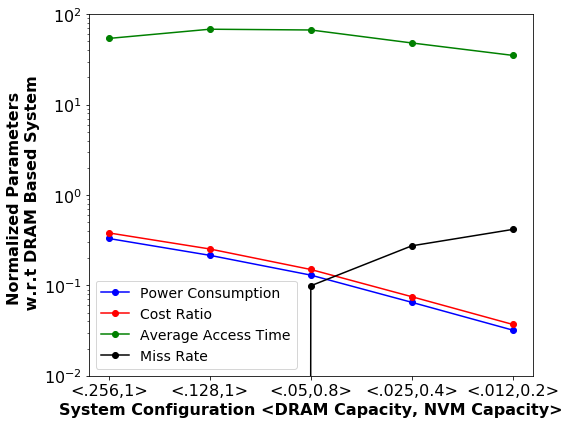

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
import matplotlib as mpl
# index = np.arange(n_groups)
# print(index)
# bar_width = 0.05
fig, ax = plt.subplots(figsize=(8,6))
ax.set_yscale('log')
# opacity = 0.4
error_config = {'ecolor': '0.3'}
index = np.arange(5)
ax.plot(index,power,'-ok',color='b',label='Power Consumption')
ax.plot(index,cost,'-ok',color='r',label='Cost Ratio')
ax.plot(index,access_time,'-ok',color='green',label='Average Access Time')
ax.plot(index,miss_rate,'-ok',color='black',label='Miss Rate')
# print(index)
bar_width = 0.1
# ax.set_yscale('log')
opacity = 0.1
ax.set_xticks(index)
error_config = {'ecolor': '0.3'}
ax.set_ylim( (pow(10,-2),pow(10,2)))
ax.set_xticklabels(('<.256,1>', '<.128,1>', '<.05,0.8>','<.025,0.4>','<.012,0.2>'))
ax.set_xlabel('System Configuration <DRAM Capacity, NVM Capacity>',fontsize=16,fontweight='bold')
ax.set_ylabel('Normalized Parameters \n w.r.t DRAM Based System',fontsize=16,fontweight='bold')
ax.legend(fontsize=14,)
fig.tight_layout()
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)
plt.savefig('analysis.pdf', bbox_inches = 'tight')
plt.show()